### Simulating quantum systems with Pauli propagation

In this tutorial we will use the ``pauli-prop`` package to classically simulate the time dynamics of a 10-qubit kicked Ising model on a 1D spin chain. The Hamiltonian considered is:

$H = -J\sum\limits_{\langle i,j \rangle} Z_iZ_j + h\sum\limits_iX_i$

where $J>0$ describes the coupling of nearest-neighbor spins, $i<j$, and $h$ is the global transverse field. A first-order Trotter decomposition of the time-evolved operator will be implemented as a quantum circuit, $U$, over $20$ Trotter steps. The coupling constant, $J$, will be fixed at $J=-\frac{\pi}{2}$, and $h$ will be fixed at $\frac{\pi}{6}$. The $ZZ$ interactions will be implemented using Clifford gates ($CX$, $Sdg$, $\sqrt{Y}$).

Workflow:
- Create a quantum circuit implementing the Trotterized Hamiltonian
- Specify an observable to calculate the average magnetization after time evolution
- Separate the circuit into its Clifford and non-Clifford parts
- Propagate the observable through the non-Clifford part of the circuit using ``pauli-prop``
- Evolve the observable terms by the Clifford part of the circuit using ``qiskit``
- Show how running larger calculations results in more accurate expectation values

#### Create circuits and observable

First, we implement the Trotterized time evolution as a quantum circuit. We will use $\frac{\pi}{6}$ for the non-Clifford rotations about the x-axis. The further these angles are from Clifford angles (i.e. $\theta=n\frac{\pi}{2}, n \in \mathbb{Z}$), the more difficult the system will be to simulate for Pauli propagation methods.

For the choice of observable, we will consider the average single-site magnetization, $\frac{1}{N} \sum_{i=1}^{N} \langle z_i \rangle$, where $N$ is the number of spins.

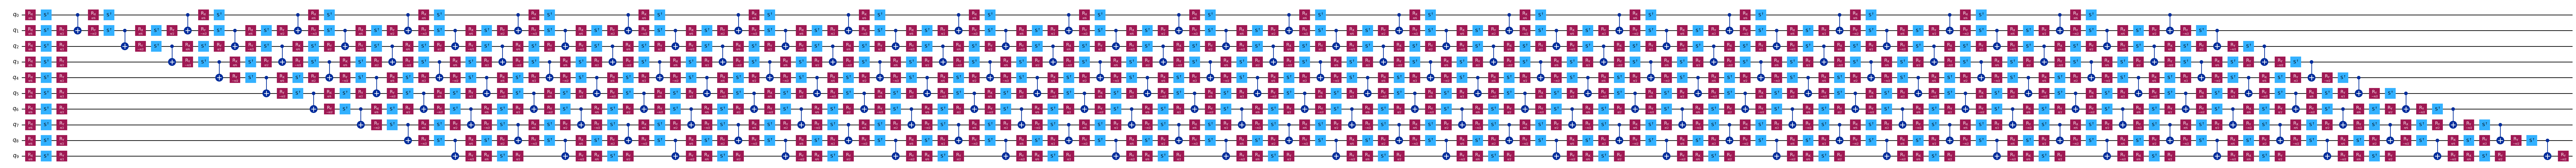

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap

num_qubits = 10
coupling_map = CouplingMap.from_line(num_qubits, bidirectional=False)

# Num Trotter steps
num_steps = 20
theta_rx = np.pi / 6

# Average single-site magnetization
observable = (
    SparsePauliOp(["I" * iq + "Z" + "I" * (num_qubits - iq - 1) for iq in range(num_qubits)])
    / num_qubits
)

# Create the Trotter circuit
num_qubits = 10
num_steps = 20
theta_rx = np.pi / 6
circuit = QuantumCircuit(num_qubits)
edges = CouplingMap.from_line(num_qubits, bidirectional=False).get_edges()
for _ in range(num_steps):
    circuit.rx(theta_rx, [i for i in range(num_qubits)])
    for edge in edges:
        circuit.sdg(edge)
        circuit.ry(np.pi / 2, edge[1])
        circuit.cx(edge[0], edge[1])
        circuit.ry(-np.pi / 2, edge[1])
circuit.draw("mpl", fold=-1)

#### Simulate the time evolution of the system

Once we have our circuit, $U$, and observable, $O$, we can easily simulate the system in a few steps:

- Separate $U$, into its Clifford, $C$, and non-Clifford, $P$, parts such that $U=PC$ using ``evolve_through_cliffords``
- Propagate $O$ through $P$, resulting in a new operator, $O^\prime$, using ``pauli_prop.propagate_through_circuit``
- Evolve $O^\prime$ through the Clifford part of the circuit using Qiskit's built-in Clifford evolution support
- Approximate the expectation value as $\langle0|O^\prime|0\rangle \approx \langle0|U^\dagger OU|0\rangle$ by summing the coefficients in $O^\prime$ associated with fully-diagonal Pauli terms (i.e. Pauli terms containing either ``I`` or ``Z`` on all qubits). Remember, this is an approximation because we truncated terms from $O^\prime$ as we propagated it through the non-Clifford part of the circuit.

In [2]:
import time

from pauli_prop import evolve_through_cliffords, propagate_through_circuit

cliff, non_cliff = evolve_through_cliffords(circuit)

max_terms_list = [10**i for i in range(8)]
approx_evs = []
durations = []
for max_terms in max_terms_list:
    st = time.time()
    evolved_obs = propagate_through_circuit(
        observable, non_cliff, max_terms=max_terms, atol=1e-12, frame="h"
    )[0]
    evolved_obs.paulis = evolved_obs.paulis.evolve(cliff, frame="h")
    durations.append(time.time() - st)
    approx_evs.append(float(evolved_obs.coeffs[~evolved_obs.paulis.x.any(axis=1)].sum()))

#### Visualize

As we run larger calculations, the expectation value approximations become more accurate. In this example, we saturate the full Pauli space at around $4^{10}\approx10^6$, which is reflected in the curve flattening out between the final two points.

While the plot below shows a monotonic convergence, Pauli propagation simulations do not generally converge monotonically. **It is not unusual to see "bumpy" behavior in these types of plots.**

Text(0.5, 1.0, 'Simulating 20-step 1D Ising Model')

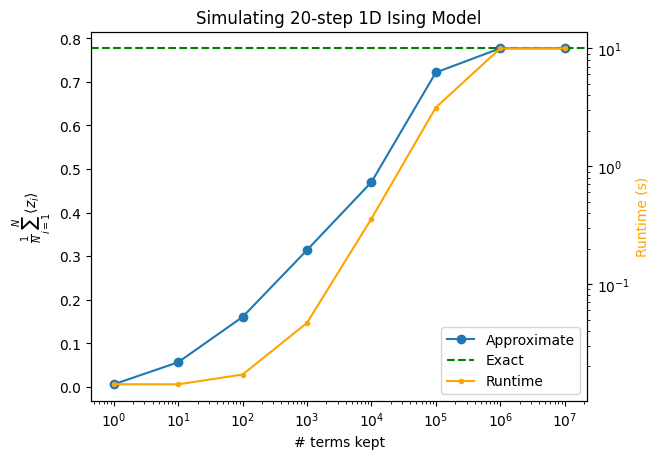

In [3]:
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator

sim_circ = circuit.copy()
sim_circ.save_statevector()
backend = AerSimulator(method="statevector")
psi = backend.run(sim_circ).result().data()["statevector"]
exact_ev = psi.expectation_value(observable)

ax1 = plt.gca()
ax1.plot(max_terms_list, approx_evs, marker="o", label="Approximate")
ax1.axhline(exact_ev, linestyle="--", color="green", label="Exact")
ax1.set_xscale("log")
ax1.set_xlabel("# terms kept")
ax1.set_ylabel(r"$\frac{1}{N} \sum_{i=1}^{N} \langle z_i \rangle$")

ax2 = ax1.twinx()
ax2.plot(max_terms_list, durations, marker=".", label="Runtime", color="orange")
ax2.set_ylabel("Runtime (s)", color="orange")
ax2.set_yscale("log")

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="lower right")

plt.title(f"Simulating {num_steps}-step 1D Ising Model")